In [39]:
%load_ext autoreload
%autoreload 2

In this notebook I look at SHAP values in the context of simple linear models and index models to make its behaviour transparent in environments that econometricians are familiar with. I will consider 
1. Linear model with independent covariates
2. Linear model with dependent covariates
3. Index model (logit) with independent covariates
4. Index model (logit) with dependent covariates

### Linear model

see goodnotes.

### Logit

With the logit, there is no nice closed form solution for the conditional expected value of the prediction. Here, I will compute these integrals exactly using numerical integration through scipy. Alternatively, and probably much faster, would be to Monte-Carlo approximate those integrals.

In [1]:
import numpy as np
import scipy.integrate as integrate
from scipy.stats import multivariate_normal as mvn
from scipy.stats import norm

In [16]:
def get_sigma_decomposition(conditioning_indices, Sigma):
    """
    Decomposes the covariance matrix Sigma into three submatrices based on the conditioning indices.
    cf: https://stats.stackexchange.com/questions/30588/deriving-the-conditional-distributions-of-a-multivariate-normal-distribution

    Parameters:
    conditioning_indices (list): List of indices representing the conditioning variables.
    Sigma (numpy.ndarray): Covariance matrix.

    Returns:
    Sigma11 (numpy.ndarray): Submatrix of Sigma containing the non-conditioning variables.
    Sigma12 (numpy.ndarray): Submatrix of Sigma containing the cross-covariance between non-conditioning and conditioning variables.
    Sigma22 (numpy.ndarray): Submatrix of Sigma containing the conditioning variables.
    """
    non_conditioning_indices = [i for i in range(Sigma.shape[0]) if i not in conditioning_indices]
    Sigma11 = Sigma[np.ix_(non_conditioning_indices, non_conditioning_indices)]
    Sigma12 = Sigma[np.ix_(non_conditioning_indices, conditioning_indices)]
    Sigma22 = Sigma[np.ix_(conditioning_indices, conditioning_indices)]
    return Sigma11, Sigma12, Sigma22

# densities of conditional normal functions
def get_conditional_params(values, conditioning_var_inds=[1, 2], mus=np.array([0, 0, 0]), Sigma=np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])):
    """
    Calculate the expected value and variance of a conditional normal distribution.

    Parameters:
    values (list): The observed values of the conditioning variables.
    conditioning_var_inds (list): The indices of the conditioning variables.
    mus (ndarray): The mean vector of the joint normal distribution.
    Sigma (ndarray): The covariance matrix of the joint normal distribution.

    Returns:
    tuple: A tuple containing the expected value and variance of the conditional normal distribution.
    """
    
    assert(len(values) == len(conditioning_var_inds))

    # generate list of variables by length of mus
    free_var_inds = [i for i in range(len(mus)) if i not in conditioning_var_inds]

    # get Sigma decomposition
    Sigma11, Sigma12, Sigma22 = get_sigma_decomposition(conditioning_var_inds, Sigma)
    # get expected value and variance of conditional normal distribution
    exp = mus[free_var_inds] + np.dot(Sigma12, np.dot(np.linalg.inv(Sigma22), (np.array(values) - mus[conditioning_var_inds])))
    sig = Sigma11 - np.dot(Sigma12, np.dot(np.linalg.inv(Sigma22), Sigma12.T))
    return exp, sig

def normal_conditional_density(x, conditioning_values, conditioning_indices, params={"mus": np.array([0, 0, 0]), "Sigma": np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])}):
    """
    Calculates the conditional density of a multivariate normal distribution.

    Parameters:
    x (array-like): The value at which to evaluate the density.
    conditioning_values (array-like): The values of the conditioning variables.
    conditioning_indices (array-like): The indices of the conditioning variables.

    Returns:
    float: The value of the conditional density at x.
    """
    exp, sig = get_conditional_params(conditioning_values, conditioning_indices, mus=params["mus"], Sigma=params["Sigma"])
    assert(len(conditioning_values) == len(conditioning_indices))
    return mvn.pdf(x, mean=exp, cov=sig)


# logit
def f_logit(x, conditioning_values, conditioning_indices, coefs = np.array([1, 1, 1])):
    # select coefs using conditioning_indices and multiply with conditioning_values
    w = coefs[conditioning_indices]
    summand = np.dot(w, conditioning_values)
    # get remaining coefs
    if x is not None:
        w_remaining = coefs[[i for i in range(len(coefs)) if i not in conditioning_indices]]
        summand += np.dot(w_remaining, x)
    return np.sum(np.exp(summand)/(1 + np.exp(summand))) # sum to return scalar

In [10]:
# integrals for 3 variables
def E_f(values, conditioning_vars, params={"mus": np.array([0, 0, 0]), "Sigma": np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]), "coefs": np.array([1, 1, 1])}):
    """
    Calculate the expected value of an outcome function f_logit under different conditioning variables with normal distributions for arbitrary parameters.

    Parameters:
    values (list): List of values for the conditioning variables.
    conditioning_vars (list): List of indices of the conditioning variables.
    params (dict): Dictionary of parameters for the function f_logit.

    Returns:
    tuple: A tuple containing the result and error of the calculation.
    """

    assert(len(values) == len(conditioning_vars))
    normal_params = {"mus": params["mus"], "Sigma": params["Sigma"]}

    if len(conditioning_vars) == 3:
        result = f_logit(x = None, conditioning_values=values, conditioning_indices=conditioning_vars)
        error = None

    if len(conditioning_vars) == 2:
        result, error = integrate.quad(lambda x: normal_conditional_density(x, conditioning_values=values, conditioning_indices=conditioning_vars, params=normal_params) * f_logit(x, conditioning_values=values, conditioning_indices=conditioning_vars, coefs=params["coefs"]), -100, 100, epsabs=1.49e-04, epsrel=1.49e-04)
    
    if len(conditioning_vars) == 1:
        result, error = integrate.dblquad(lambda x,y: normal_conditional_density((x,y), conditioning_values=values, conditioning_indices=conditioning_vars, params=normal_params) * f_logit((x,y), conditioning_values=values, conditioning_indices=conditioning_vars, coefs=params["coefs"]), -100, 100, -100, 100, epsabs=1.49e-04, epsrel=1.49e-04)

    if len(conditioning_vars) == 0:
        result, error = integrate.tplquad(lambda x,y,z: mvn.pdf((x,y,z), mean=params["mus"], cov=params["Sigma"]) * f_logit((x,y,z), conditioning_values=values, conditioning_indices=conditioning_vars, coefs=params["coefs"]), -100, 100, -100, 100, -100, 100, epsabs=1.49e-04, epsrel=1.49e-04)

    return result, error


### checks and tests

In [35]:
coefs = np.array([1, 1, 1])
coefs[[1,2]]

array([1, 1])

In [36]:
f_logit(x = 2, conditioning_values = [0, 0], conditioning_indices = [1, 2], coefs = np.array([1, 1, 1]))

0.8807970779778824

In [37]:
f_logit(x = (0,0), conditioning_values = [0], conditioning_indices = [1], coefs = np.array([1, 1, 1]))

0.5

In [38]:
f_logit(x = (0,0,0), conditioning_values = [], conditioning_indices = [], coefs = np.array([1, 1, 1]))

0.5

In [8]:
get_sigma_decomposition([1,2], Sigma = np.array([[1,0,0],[0,1,0],[0,0,1]]))

(array([[1]]),
 array([[0, 0]]),
 array([[1, 0],
        [0, 1]]))

In [9]:
get_sigma_decomposition([2], Sigma = np.array([[1,0,0],[0,1,0],[0,0,1]]))

(array([[1, 0],
        [0, 1]]),
 array([[0],
        [0]]),
 array([[1]]))

In [10]:
get_conditional_params(values = [0], conditioning_var_inds = [2])

(array([0., 0.]),
 array([[1., 0.],
        [0., 1.]]))

In [11]:
normal_conditional_density(x = [0,0], conditioning_values=[0], conditioning_indices=[2])

0.15915494309189535

In [39]:
# check if the conditional densities are correct by integrating

integrate.dblquad(lambda x,y: normal_conditional_density((x,y), [0], [2]), -np.inf, np.inf, -np.inf, np.inf, epsabs=1.49e-04, epsrel=1.49e-04)

(1.0000000011805943, 0.0001413029331700994)

In [40]:
integrate.quad(lambda x: normal_conditional_density(x, [0,3], [1,2]), -np.inf, np.inf, epsabs=1.49e-04, epsrel=1.49e-04)

(0.9999999997941593, 9.361124086700034e-05)

In [41]:
integrate.quad(lambda x: f_logit(x, [0,0], [1,2]) * normal_conditional_density(x, [0,0], [1,2]), -100, 100)

(0.5000000000000001, 5.943013844712378e-13)

In [42]:
mvn.pdf((0,0,0), np.array([0,0,0]), np.array([[1,0,0],[0,1,0],[0,0,1]]))

0.06349363593424098

For some reason this only works if I throw in bounds of 100, for larger (e.g. np.inf) it doesnt compute the integral, I guess it has trouble with large values of the logic and small tail probability masses.

In [16]:
E_f(values = [1,2], conditioning_vars = [1,2])

(0.9306761419957146, 7.25675477206413e-13)

In [17]:
E_f(values = [1], conditioning_vars = [2])

(0.6750567023488913, 1.4870789199628173e-08)

### SHAP value computation via Kernel representation

The code is based on a description of the Kernel Shap procedure from KJERSTI AAS, MARTIN JULLUM, and ANDERS LØLAND in EXPLAINING INDIVIDUAL PREDICTIONS WHEN FEATURES ARE DEPENDENT:
MORE ACCURATE APPROXIMATIONS TO SHAPLEY VALUES.

In [63]:
import pandas as pd
import numpy as np
import math
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

class ShapleyWLS:
    def __init__(self, SHAP_value_function, data_instance, value_function_params):
        self.SHAP_value_function = SHAP_value_function
        self.data_instance = data_instance
        self.value_function_params = value_function_params
        self.M = len(data_instance)
        self.Z = None
        self.W = None
        self.v = None
        self.shapley_values = None

        

    def build_Z(self):
        self.Z = np.ones((2**self.M, self.M+1))
        self.Z[:, 1:] = np.unpackbits(np.arange(2**self.M, dtype=np.uint8)[:, np.newaxis], axis=1)[:, -self.M:]
        print("Z built.")

    def build_W(self):
        self.W = np.zeros((2**self.M, 2**self.M))
        for i in range(2**self.M):
            sum_Z = int(np.sum(self.Z[i, 1:]))
            if sum_Z == 0 or sum_Z == self.M:
                self.W[i, i] = 10e6 # should be infinity, in practice set to large constant
            else:
                self.W[i, i] = (self.M-1)/(math.comb(self.M, sum_Z) * (self.M-sum_Z) * sum_Z)
        print("W built.")

    def build_v(self):
        self.v = np.zeros((2**self.M, 1))
        for i in tqdm.tqdm(range(2**self.M)):
            conditioning_indices = np.where(self.Z[i, 1:] == 1)[0] # indices of "playing" features
            self.v[i] = self.SHAP_value_function(values = self.data_instance[conditioning_indices] , conditioning_vars = conditioning_indices, params = self.value_function_params)[0]
            print(f"v_{i}: {self.v[i]}")

    def compute_shapley_values(self):
        self.build_Z()
        self.build_W()
        self.build_v()
        self.shapley_values = np.dot(np.dot(np.dot(np.linalg.inv(np.dot(np.dot(self.Z.T, self.W), self.Z)), self.Z.T), self.W), self.v)
        return self.shapley_values
    
    def get_prediction(self):
        return self.SHAP_value_function(values = self.data_instance, conditioning_vars = [0,1,2], params = self.value_function_params)[0]
    
    def plot_waterfall(self):
        assert self.shapley_values is not None; "Shapley values not computed yet."

         # get model prediction for the instance
        prediction = self.get_prediction()
        df = pd.DataFrame({"feature": ["default","x1", "x2", "x3"], "SHAP": self.shapley_values.flatten(), "value": np.insert(self.data_instance,0,0)})
        df["cumulative_SHAP"] = df["SHAP"].cumsum()

        # build waterfall plot
        f = plt.figure(figsize=(10, 5))
        sns.barplot(x="feature", y="cumulative_SHAP", data=df, color="lightblue", label="Cumulative SHAP")
        sns.barplot(x="feature", y="SHAP", data=df, color="green", width=0.1, alpha=0.2, label="Individual SHAP")
        sns.scatterplot(x="feature", y="value", data=df, color="red", alpha=0.6, label="Feature Value")
        ax = plt.gca()
        ax.axhline(prediction, color='blue', linewidth=2, linestyle='--', label = "Model Prediction")

        # add legend
        plt.legend()

        plt.show()

Let's try if this works in the logit for a (0,0,0) instance: all instances are equal to their individual expectation, so the default shap value $\phi(\emptyset) = 0.5$ and the other are all zero...

In [59]:
SHAP_WLS_test = ShapleyWLS(SHAP_value_function = E_f, data_instance = np.array([0,1,0]), value_function_params = {"mus": np.array([0, 0, 0]), "Sigma": np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]), "coefs": np.array([1, 1, 1])})
SHAP_WLS_test.get_prediction()

0.7310585786300049

In [43]:
sv2 = SHAP_WLS_test.compute_shapley_values()
sv2

Z built.
W built.


  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [01:55<13:31, 115.99s/it]

v_0: [0.50000741]


 25%|██▌       | 2/8 [01:58<04:56, 49.46s/it] 

v_1: [0.50000004]


 38%|███▊      | 3/8 [02:01<02:20, 28.02s/it]

v_2: [0.6750569]
v_3: [0.69673467]


100%|██████████| 8/8 [02:04<00:00, 15.56s/it]

v_4: [0.50000004]
v_5: [0.5]
v_6: [0.69673467]
v_7: [0.73105858]


array([[0.50000741],
       [0.0150518 ],
       [0.20094756],
       [0.0150518 ]])

Let's see the decomposition via a waterfall plot

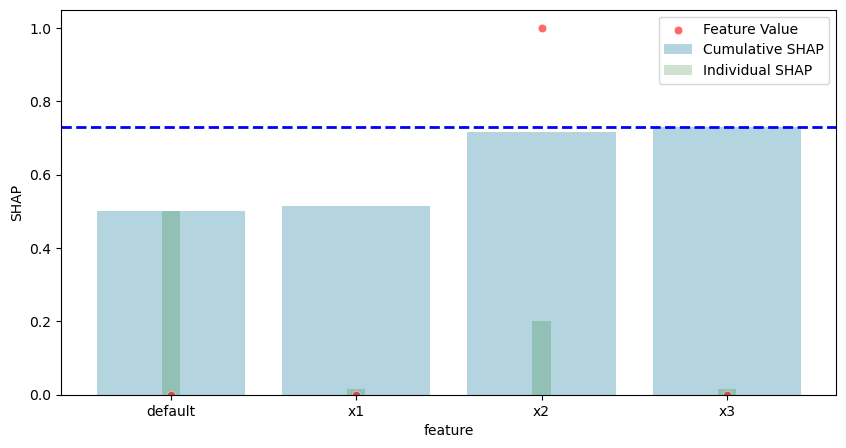

In [61]:
SHAP_WLS_test.plot_waterfall()

Looks good!

### Running some Analysis

What is the relationship to familiar econometric concepts in the logit, such as the partial effects?